In [ ]:
## 기본 라이브러리 호출
import numpy as np
import pandas as pd

## Matplot 호출 및 plotting style 정의 
import matplotlib.pyplot as plt
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['image.cmap'] = 'jet'

# Tensorflow Neural network Prediction

## What can tensorflow do?

The short answer: it allows machine learning researcher to experiment with deep neural nets  more easily. Here, "more easily" means it takes less time to construct artificial neural networks, less time to train them (this is arguable, as is always the case when speed is concerned), and less time to deploy them.

**Do not expect:** do not expect magic things to come from TensorFlow. There is none. A wealth of deep learning frameworks already exist in the wild and TensorFlow is just one of them. It will not give you powerful AI overnight, nor will it help your smartphone to recognize cats. It is a tool for deep learning research that will hopefully make it a bit less cumbersome.

**Who should be excited:** deep learning researchers who construct and experiment with large number of networks, researchers who are too lazy to get their hands dirty on serious code, and companies that benefit from being able to quickly train and deploy their models. Basically if you consider yourself a member of the general public, it's got nothing to do with you.


## The model in theory

https://github.com/alberduris/SirajsCodingChallenges/tree/master/Stock%20Market%20Prediction

We are going to use 4 features: The **price** itself and three extra technical indicators.
- MACD (Trend)
    https://md2biz.tistory.com/397#:~:text=MACD%EC%9D%98%20%EC%A0%95%EC%9D%98&text=%EC%9A%B0%EB%A6%AC%EB%A7%90%EB%A1%9C%20%EC%9D%B4%EB%8F%99%ED%8F%89%EA%B7%A0%EC%88%98%EB%A0%B4,%EB%B3%B4%EA%B8%B0%20%EC%89%BD%EA%B2%8C%20%EB%82%98%ED%83%80%EB%82%B8%20%EC%A7%80%ED%91%9C%EC%9E%84.
- Stochastics Oscillator (Momentum)
    https://wendys.tistory.com/176
- Average True Range (Volume)

    https://layhope.tistory.com/241

## Feature Engineering

**Exponential Moving Average:** Is a type of infinite impulse response filter that applies weighting factors which decrease exponentially. The weighting for each older datum decreases exponentially, never reaching zero. 

**MACD:**  The Moving Average Convergence/Divergence oscillator (MACD) is one of the simplest and most effective momentum indicators available. The MACD turns two trend-following indicators, moving averages, into a momentum oscillator by subtracting the longer moving average from the shorter moving average.

**Stochastics oscillator:** The Stochastic Oscillator is a momentum indicator that shows the location of the close relative to the high-low range over a set number of periods.

**Average True Range:** Is an indicator to measure the volalitility (NOT price direction). The largest of:
- Method A: Current High less the current Low
- Method B: Current High less the previous Close (absolute value)
- Method C: Current Low less the previous Close (absolute value)


In [ ]:
## 구글 드라이브와 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df

,Close,Open,High,Low
Date,,,,
13.08.2007,1.3611,1.3687,1.3710,1.3603
14.08.2007,1.3537,1.3607,1.3630,1.3531
15.08.2007,1.3426,1.3536,1.3539,1.3425
16.08.2007,1.3424,1.3426,1.3449,1.3359
17.08.2007,1.3476,1.3420,1.3546,1.3371
...,...,...,...,...
04.09.2017,1.1896,1.1858,1.1923,1.1853
05.09.2017,1.1914,1.1896,1.1941,1.1868
06.09.2017,1.1917,1.1914,1.1951,1.1903


In [ ]:
## Load passenger data set and safe to DataFrame
datapath = '/content/drive/MyDrive/Time Series/EURUSD.csv'
df = pd.read_csv(datapath, usecols=[0,1,2,3,4])
df.set_index('Date', inplace=True)
df = df.iloc[::-1] ## 오름차순

df["Close"] = (df["Close"].str.split()).apply(lambda x: float(x[0].replace(',', '.')))
df["Open"] = (df["Open"].str.split()).apply(lambda x: float(x[0].replace(',', '.')))
df["High"] = (df["High"].str.split()).apply(lambda x: float(x[0].replace(',', '.')))
df["Low"] = (df["Low"].str.split()).apply(lambda x: float(x[0].replace(',', '.')))

dfPrices = pd.read_csv(datapath,usecols=[0,1])
dfPrices.set_index('Date', inplace=True)
dfPrices = dfPrices.iloc[::-1]
dfPrices["Close"] = (dfPrices["Close"].str.split()).apply(lambda x: float(x[0].replace(',', '.')))
print(df.shape, dfPrices.shape)

(2630, 4) (2630, 1)


In [ ]:
dfPrices.head()

,Close
Date,
13.08.2007,1.3611
14.08.2007,1.3537
15.08.2007,1.3426
16.08.2007,1.3424
17.08.2007,1.3476


In [ ]:
def MACD(df, period1, period2, periodSignal):
    EMA1 = pd.DataFrame.ewm(df, span=period1).mean()
    EMA2 = pd.DataFrame.ewm(df, span=period2).mean()
    MACD = EMA1 - EMA2
    
    Signal = pd.DataFrame.ewm(MACD, periodSignal).mean()
    
    Histogram = MACD - Signal
    
    return Histogram

def stochastics_oscillator(df, period):
    l, h = pd.DataFrame.rolling(df, period).min(), pd.DataFrame.rolling(df, period).max()
    k = 100 * (df - l) / (h - l)
    return k

def ATR(df,period):
    '''
    Method A: Current High less the current Low
    '''
    df['H-L'] = abs(df['High'] - df['Low'])
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    TR = df[['H-L','H-PC','L-PC']].max(axis=1) # Pandas Series
    return TR.to_frame()

# Plotting

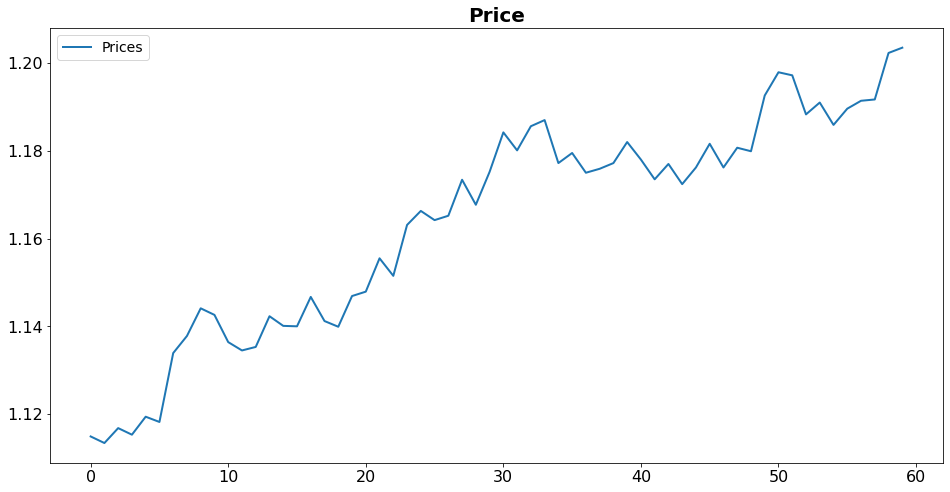

In [ ]:
price = dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)].values.ravel()
prices = dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)].values.ravel()
plt.figure()
plt.plot(prices,label='Prices')
plt.title('Price')
plt.legend(loc='upper left')
plt.show()

### MACD

In [ ]:
macd = MACD(dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)],12,26,9)

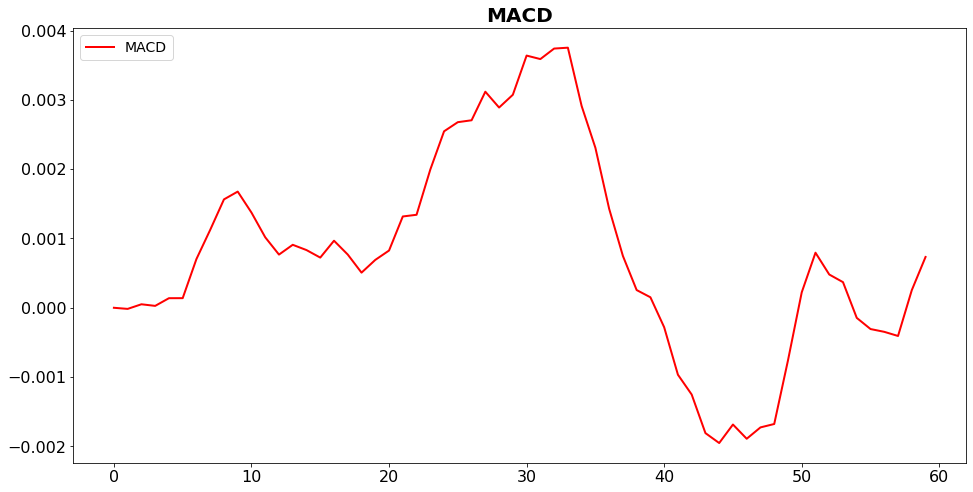

In [ ]:
plt.figure()
plt.plot(macd.values, label='MACD', color='red')
plt.title('MACD')
plt.legend(loc='upper left')
plt.show()

### Stochastics Oscillator

In [ ]:
stochastics = stochastics_oscillator(dfPrices.iloc[len(dfPrices.index)-60:len(dfPrices.index)],14)

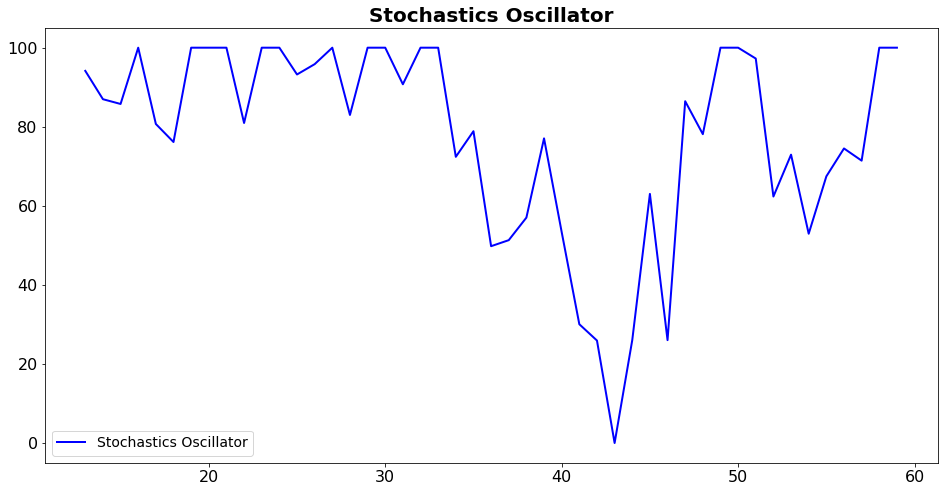

In [ ]:
## First 100 points because it's too dense
plt.plot(stochastics[0:100].values,label='Stochastics Oscillator',color='blue')
plt.title('Stochastics Oscillator')
plt.legend(loc='best')
plt.show()

### Average True Range

In [ ]:
atr = ATR(df.iloc[len(df.index)-60:len(df.index)],14)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

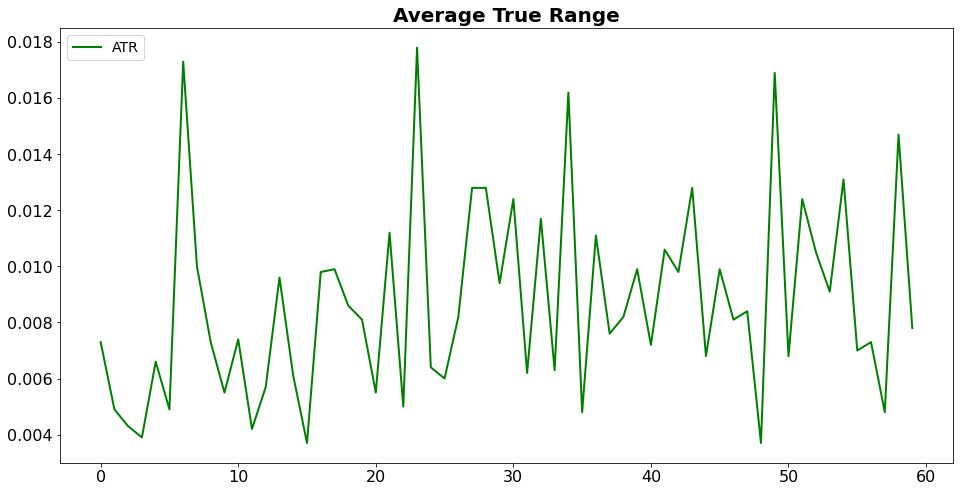

In [ ]:
plt.figure()
## First 100 points because it's too dense
plt.plot(atr[0:100].values, label='ATR', color='green')
plt.title('Average True Range')
plt.legend(loc='upper left')
plt.show()

## Create complete DataFrame & Save Data

In [ ]:
dfPriceShift = dfPrices.shift(-1)
dfPriceShift.rename(columns={'Close':'CloseTarget'}, inplace=True)

In [ ]:
dfPriceShift

,CloseTarget
Date,
13.08.2007,1.3537
14.08.2007,1.3426
15.08.2007,1.3424
16.08.2007,1.3476
17.08.2007,1.3473
...,...
04.09.2017,1.1914
05.09.2017,1.1917
06.09.2017,1.2023


In [ ]:
print(dfPrices.head())
print(dfPriceShift.head())

             Close
Date              
13.08.2007  1.3611
14.08.2007  1.3537
15.08.2007  1.3426
16.08.2007  1.3424
17.08.2007  1.3476
            CloseTarget
Date                   
13.08.2007       1.3537
14.08.2007       1.3426
15.08.2007       1.3424
16.08.2007       1.3476
17.08.2007       1.3473


In [ ]:
macd = MACD(dfPrices,12,26,9)
macd.rename(columns={'Close':'MACD'}, inplace=True)

stochastics = stochastics_oscillator(dfPrices,14)
stochastics.rename(columns={'Close':'Stochastics'}, inplace=True)

atr = ATR(df,14)
atr.rename(columns={0:'ATR'}, inplace=True)

## Concatenate all together
final_data = pd.concat([dfPrices,dfPriceShift,macd,stochastics,atr], axis=1)
## Delete the entries with missing values 
final_data = final_data.dropna()

In [ ]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2616 entries, 30.08.2007 to 07.09.2017
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Close        2616 non-null   float64
 1   CloseTarget  2616 non-null   float64
 2   MACD         2616 non-null   float64
 3   Stochastics  2616 non-null   float64
 4   ATR          2616 non-null   float64
dtypes: float64(5)
memory usage: 122.6+ KB


In [ ]:
final_data

,Close,CloseTarget,MACD,Stochastics,ATR
Date,,,,,
30.08.2007,1.3638,1.3630,0.001322,83.268482,0.0086
31.08.2007,1.3630,1.3621,0.001137,80.155642,0.0100
03.09.2007,1.3621,1.3607,0.000913,76.653696,0.0053
04.09.2007,1.3607,1.3650,0.000640,71.206226,0.0076
05.09.2007,1.3650,1.3689,0.000659,85.844749,0.0104
...,...,...,...,...,...
01.09.2017,1.1859,1.1896,-0.000909,52.941176,0.0131
04.09.2017,1.1896,1.1914,-0.001047,67.450980,0.0070
05.09.2017,1.1914,1.1917,-0.001063,74.509804,0.0073


In [ ]:
final_data.to_csv('/content/drive/MyDrive/Time Series/EURUSD_indicators.csv', index=False)

# Recurrent Neural Network

In [ ]:
import math

## Deep learning
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import plot_model 

## sklearn functionalities
from sklearn.preprocessing import MinMaxScaler

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Time Series/EURUSD_indicators.csv')
dataset.head()

,Close,CloseTarget,MACD,Stochastics,ATR
0,1.3638,1.3630,0.001322,83.268482,0.0086
1,1.3630,1.3621,0.001137,80.155642,0.0100
2,1.3621,1.3607,0.000913,76.653696,0.0053
3,1.3607,1.3650,0.000640,71.206226,0.0076
4,1.3650,1.3689,0.000659,85.844749,0.0104


In [ ]:
## normalize
datasetNorm = (dataset - dataset.mean()) / (dataset.max() - dataset.min())
datasetNorm.head()

,Close,CloseTarget,MACD,Stochastics,ATR
0,0.121300,0.119981,0.027770,0.336375,-0.076375
1,0.119872,0.118375,0.023829,0.305247,-0.049555
2,0.118265,0.115875,0.019035,0.270227,-0.139593
3,0.115766,0.123552,0.013213,0.215753,-0.095532
4,0.123443,0.130515,0.013620,0.362138,-0.041892


In [ ]:
## Hyperparameters definition
num_epochs = 100

batch_size = 2

total_series_length = len(dataset.index)

lags = 3 # The size of the sequence

num_features = 4
num_classes = 1 #[1,0]

num_batches = batch_size
#num_batches = total_series_length // batch_size // truncated_backprop_length
#num_batches = total_series_length // batch_size // truncated_backprop_length

min_test_size = 100

print('The total series length is: %d' %total_series_length)
print('The current configuration gives us %d batches of %d observations each one looking %d steps in the past' 
      %(num_batches,batch_size,truncated_backprop_length))

The total series length is: 2616


NameError: ignored

## Train Test Split

In [ ]:
train_ratio = 0.9
datasetTrain = datasetNorm[:int(len(datasetNorm)*train_ratio)]
datasetTest = datasetNorm[int(len(datasetNorm)*train_ratio):]

print(datasetTrain.shape, datasetTest.shape)

(2354, 5) (262, 5)


In [1]:
def prepare_data(data, lags=1):
    """
    Create lagged data from an input time series
    """
    x_train = data[['Close', 'MACD', 'Stochastics', 'ATR']].values
    y_train = data['CloseTarget'].values
    X, y = [], []
    for row in range(len(data) - lags - 1):
        a = x_train[row:(row + lags), :]       
        X.append(a)
        y.append(y_train[row + lags])
    return np.array(X), np.array(y)

In [ ]:
print(datasetTrain.head())

X_train, y_train = prepare_data(datasetTrain, lags=lags)

print(X_train.shape, y_train.shape)

      Close  CloseTarget      MACD  Stochastics       ATR
0  0.121300     0.119981  0.027770     0.336375 -0.076375
1  0.119872     0.118375  0.023829     0.305247 -0.049555
2  0.118265     0.115875  0.019035     0.270227 -0.139593
3  0.115766     0.123552  0.013213     0.215753 -0.095532
4  0.123443     0.130515  0.013620     0.362138 -0.041892
(2350, 3, 4) (2350,)


In [ ]:
print(datasetTest.head())

X_test, y_test = prepare_data(datasetTest, lags=lags)
#xTest = datasetTest[['Close','MACD','Stochastics','ATR']].values
#yTest = datasetTest['CloseTarget'].values
print(X_test.shape, y_test.shape)

         Close  CloseTarget      MACD  Stochastics       ATR
2354 -0.307016    -0.302979 -0.015725     0.028280 -0.158750
2355 -0.303088    -0.307978 -0.007824     0.174145 -0.059134
2356 -0.308087    -0.307799 -0.006709     0.055838 -0.072544
2357 -0.307909    -0.310299 -0.005958     0.153690 -0.130015
2358 -0.310408    -0.304943 -0.007783     0.053690 -0.128099
(258, 3, 4) (258,)


## Visualize starting price data

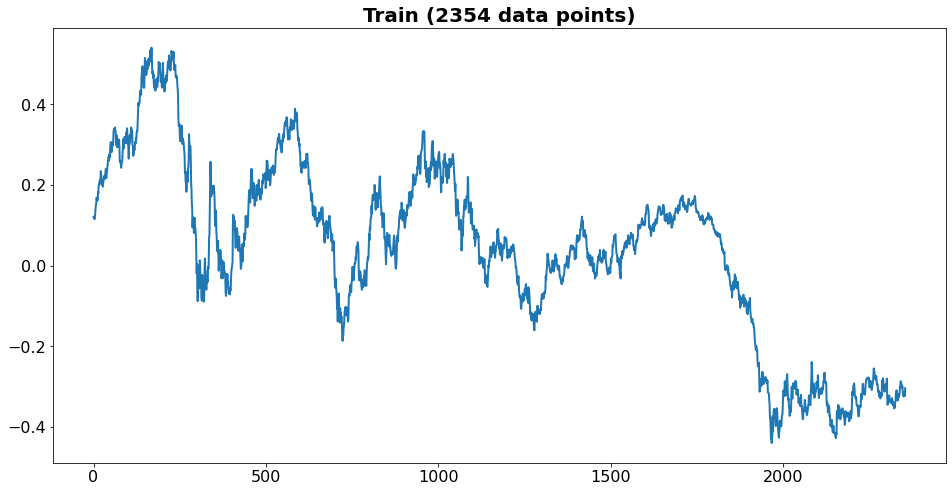

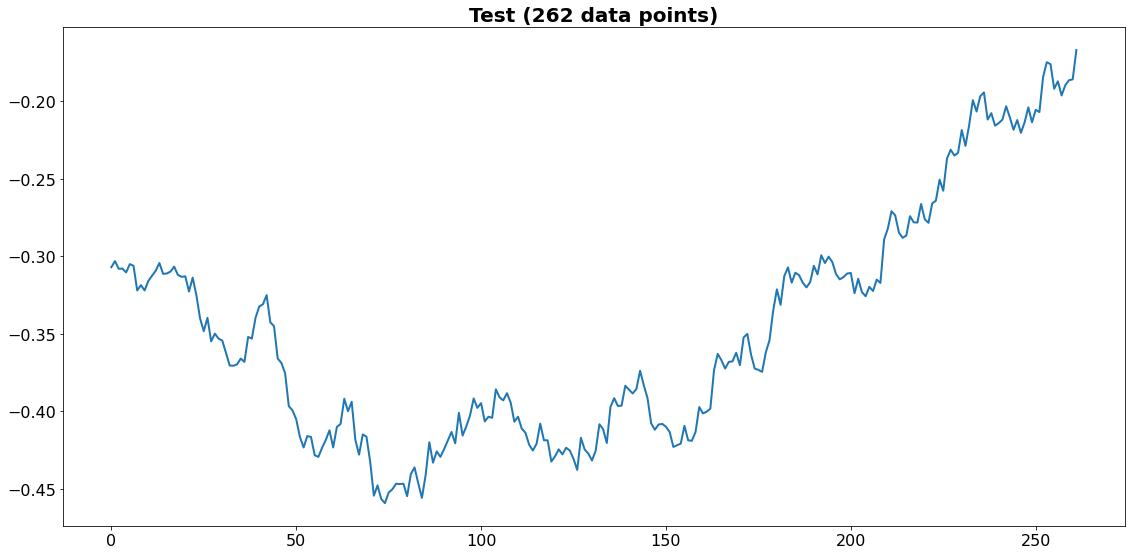

In [ ]:
plt.plot(xTrain[:,0])
plt.title('Train (' +str(len(X_train))+' data points)')
plt.show()
plt.plot(xTest[:,0])
plt.title('Test (' +str(len(X_test))+' data points)')
plt.tight_layout()
plt.show()

## LSTM model building and train

In [ ]:
## Create and fit the LSTM network
mdl = Sequential()
mdl.add(Dense(6, input_shape=(3, 4), activation='relu'))
mdl.add(LSTM(state_size, activation='relu'))
mdl.add(Dense(1))
mdl.compile(loss='mean_squared_error', optimizer='adam')
print(X_train.shape, y_train.shape)
mdl.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1)

(2350, 3, 4) (2350,)
Epoch 1/100
294/294 [==============================] - 2s 2ms/step - loss: 0.0282
Epoch 2/100
294/294 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 3/100
294/294 [==============================] - 1s 2ms/step - loss: 7.1980e-04
Epoch 4/100
294/294 [==============================] - 1s 2ms/step - loss: 6.6980e-04
Epoch 5/100
294/294 [==============================] - 1s 2ms/step - loss: 6.2973e-04
Epoch 6/100
294/294 [==============================] - 1s 2ms/step - loss: 5.8232e-04
Epoch 7/100
294/294 [==============================] - 1s 2ms/step - loss: 5.8625e-04
Epoch 8/100
294/294 [==============================] - 1s 2ms/step - loss: 6.5277e-04
Epoch 9/100
294/294 [==============================] - 1s 2ms/step - loss: 5.7461e-04
Epoch 10/100
294/294 [==============================] - 1s 2ms/step - loss: 6.0080e-04
Epoch 11/100
294/294 [==============================] - 1s 2ms/step - loss: 5.8475e-04
Epoch 12/100
294/294 [=================

## Prediction, Loss & Optimizer

In [ ]:
## Make predictions
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)
print(train_predict.shape, test_predict.shape)

(2350, 1) (258, 1)


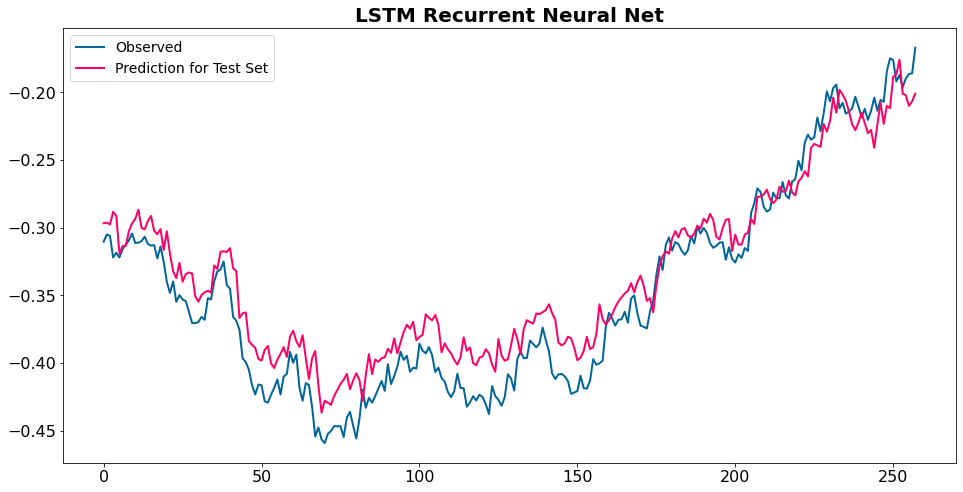

In [ ]:
## Shift train predictions for plotting
train_predict_plot = np.empty_like(y_train)
train_predict_plot[:] = np.nan
train_predict_plot = train_predict

## Shift test predictions for plotting
test_predict_plot = np.empty_like(y_test)
test_predict_plot[:] = np.nan
test_predict_plot = test_predict

## Plot observation and predictions
plt.plot(y_test, label='Observed', color='#006699');
#plt.plot(train_predict_plot, label='Prediction for Train Set', color='#006699', alpha=0.5);
plt.plot(test_predict_plot, label='Prediction for Test Set', color='#ff0066');
plt.legend(loc='upper left')
plt.title('LSTM Recurrent Neural Net')
plt.show()